## Imports

In [1]:
import pdf2image
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Extracting Images from PDFs

In [2]:
pdf_paths = []
# pdf_paths = [f"resources/pdfs/{pdf}" for pdf in os.listdir("resources/pdfs") if pdf.endswith(".pdf")]
for pdf_path in pdf_paths:
    pdf_images = pdf2image.convert_from_path(pdf_path)
    pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]
    os.mkdir(f"resources/images/{pdf_name}")
    for i, pdf_image in enumerate(pdf_images):
        pdf_image.save(f"resources/images/{pdf_name}/page{i+1}.png", "PNG")

In [3]:
def show_image(image):
    # Convert image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    # Remove all white space around image
    plt.tight_layout()
    # Set padding to 0, so the text is as close as possible to the image
    plt.margins(0)

    plt.show()

In [4]:
def recognize_lines_old(image_path):
    image_path = "resources/images/pascha_canon_english/page1.png"
    image = cv2.imread(image_path)
    # convert to grayscale
    grayscaled_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # threshold to get just the signature ( INVERTED)
    thresholded_image = cv2.threshold(grayscaled_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    # Find continuous blocks of horizontal white space
    white_blocks = []
    current_block_start = None
    for row in range(thresholded_image.shape[0]):
        if np.sum(thresholded_image[row, :]) == 0:  # White space found
            if current_block_start is None:
                current_block_start = row
        else:  # End of white space
            if current_block_start is not None:
                block_width = row - current_block_start
                white_blocks.append((current_block_start, row, block_width))
                current_block_start = None
    # Filter out blocks that are too small
    white_blocks = list(filter(lambda b: b[2] > 15, white_blocks))
    # Draw yellow rectangles around the white space blocks on the original image
    for block in white_blocks:
        start_row, end_row, block_width = block
        cv2.rectangle(thresholded_image, (0, start_row), (image.shape[1], end_row), (255, 255, 255), thickness=cv2.FILLED)
    # show the image
    show_image(thresholded_image)

In [93]:
def recognize_lines(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ## (2) threshold
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)

    ## (3) minAreaRect on the nozeros
    pts = cv2.findNonZero(threshed)
    ret = cv2.minAreaRect(pts)

    (cx,cy), (w,h), ang = ret
    if w>h:
        w,h = h,w
        ang += 90
    # If angle is close to 180, then make it closer to 0
    if ang > 90:
        ang -= 180
    ## (4) Find rotated matrix, do rotation
    M = cv2.getRotationMatrix2D((cx,cy), ang, 1.0)
    rotated = cv2.warpAffine(threshed, M, (img.shape[1], img.shape[0]))

    ## (5) find and draw the upper and lower boundary of each lines
    hist = cv2.reduce(rotated,1, cv2.REDUCE_AVG).reshape(-1)
    H,W = img.shape[:2]
    # Normalize the histogram to the image width
    hist = hist * (float(W) / max(hist))
    fig, ax_image = plt.subplots()
    # Display the image on the first subplot
    ax_image.imshow(rotated, cmap='gray')
    # Create the x-axis values for the histogram
    x = range(len(hist))
    # Plot the histogram on the second subplot
    ax_image.plot(hist, np.arange(H), color='red')
    # Set the limits of the x-axis for the histogram subplot
    ax_image.set_xlim(0, W)
    plt.show()

    # Find the upper and lower boundaries of each line
    th = 0
    uppers = [y for y in range(H-1) if hist[y]<=th and hist[y+1]>th]
    lowers = [y for y in range(H-1) if hist[y]>th and hist[y+1]<=th]

    rotated = cv2.cvtColor(rotated, cv2.COLOR_GRAY2BGR)
    # Make everything not in between the upper and lower boundaries red
    painting = True
    for y in range(rotated.shape[0]):
        if y in uppers or y in lowers:
            painting = not painting
        if painting:
            rotated[y, :] = [0, 0, 255]   
    return rotated

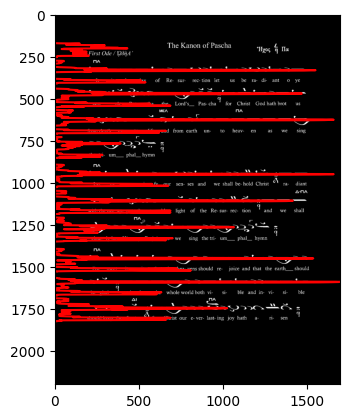

In [95]:
n=2
i=0
# Make a directory for the highlighted lines if it doesn't exist
if not os.path.exists("resources/images/pascha_canon_english/lines"):
    os.mkdir("resources/images/pascha_canon_english/lines")
# For each png file in directory, make an image with the lines highlighted
for file in sorted(os.listdir("resources/images/pascha_canon_english")):
    if i == n:
        break
    i += 1
    if not file.endswith(".png"):
        continue
    new_img = recognize_lines(f"resources/images/pascha_canon_english/{file}")
    # Split the file path and name
    file_path, file_name = os.path.split(file)
    # Save the image to resources/images/pascha_canon_english/lines
    cv2.imwrite(f"resources/images/pascha_canon_english/lines/{file_name}", new_img)